In [15]:
#import relevant libraries

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from math import *
import matplotlib.ticker
import LISA_tools as LISA

## Set physical and LISA constants

In [16]:
""" Cosmological values """
H0      = 69.6      # Hubble parameter today
Omega_m = 0.286     # density parameter of matter

""" LISA arm length """
L = 2.5e9 # meters

""" Transfer Frequency """
f_star = LISA.C/(2.*np.pi*L)

""" Observation Period """
Tobs = 4.*LISA.YEAR

""" Number of Michelson Data Channels """
NC = 2


G = 6.67430e-11
c = 299792458.
Gpc = 3.08567758149137e25/c #Giga parsec in seconds
Msun = 1.9885e30*G/c**3 #Mass of Sun in seconds


In [17]:
def inner_inspiral_new(m1,m2):
    m=m1+m2
    eta=m1*m2/m**2
    return (256/5*eta*m**3*4*LISA.YEAR/(1-(90./100)**4))**(1./4)

## Import the Noise Curve (corresponding to 4yr LISA lifetime as default)

In [18]:
freq_arr = np.loadtxt('Sn_4yr.dat')[:,0]
Sn_arr = np.loadtxt('Sn_4yr.dat')[:,1]

## Compute the frequency as a function of time

In [19]:
def aTOfreq(a,m):
    return (m/a**3)**(1./2)/np.pi

def freqTOa(f,m):
    return (m/(np.pi*f)**2)**(1./3.)

#Compute the GW frequency as a function of time

def freq(f_init,m,eta,t):
    a_in = (m/(np.pi*f_init)**2)**(1./3.)
    epsilonrr = (m/a_in)**(5./2)
    a=(a_in**4-256/5*eta*epsilonrr*(m)**(1./2)*a_in**(5./2.)*t)**(1./4.)
    return (m/a**3)**(1./2.)/np.pi

## Define source parameters

In [20]:
D_l = 1.0*Gpc #distance to source
#masses in detector frame
m1=1.0e4*Msun 
m2=1.0e4*Msun

#Find redshift 
z=sp.optimize.root(LISA.get_z, 1., args=(D_l, Omega_m, H0)).x[0]

m=m1+m2
mu=m1*m2/m
eta=mu/m
Mc=eta**(3./5.)*m

f_ISCO = 6.0**(-3./2)/m

#initial orbital separation based on delta a/ a_init ~ 10%
a_init= 480*m  #inner_inspiral_new(m1,m2)
f_init=aTOfreq(a_init,m)

## Define GW inspiral strain and SNR

In [21]:
def h_insp(f,A):
    #f is array like
    return A*f**(-7./6.)

def S_analytic(f,fstar,L,NC,Tobs):
    Sn = LISA.get_Sn_approx(f,f_star,L,NC)
    Sc = LISA.get_Sc_est(f,Tobs,NC)
    return Sn+Sc

def SNR(f,A,S,delta_f):
    #f,S are array like
    h=h_insp(f,A)
    #Compute SNR using a simple Riemann sum as an approximation to the integral. 
    return (16./5.*np.sum(h**2/S)*delta_f)**(1./2.)

## Determine Frequency Window to study

In [22]:
# Compute the maximum frequency after 4 years
#f_max= #freq(f_init,m,eta,4*LISA.YEAR)
#a_f = ((m)/(np.pi*f_max)**2)**(1./3.)
a_f = 10.1431*m
f_max=aTOfreq(a_f,m)

In [23]:
#Define the frequency window to focus on and also define the bin size
delta_f = (f_max-f_init)/100.
freq_window = np.arange(f_init,f_max,delta_f)

In [24]:
#f_max=f_max/(1+z)
#f_init=f_init/(1+z)
#delta_f=delta_f/(1+z)
#freq_window=freq_window/(1+z)
#Mc=Mc*(1+z)
#Overall constant for GW amplitude
A=np.sqrt(5./24.)*(Mc)**(5./6.)/np.pi**(2./3)/(D_l)

## Find SNR for the source

In [25]:
# Find the approximate S_n and S_c and add them to get the total noise (this is an excellent approximation for early frequencies)
S_tot_window = S_analytic(freq_window,f_star,L,NC,Tobs)
#Find the resulting SNR 
rho = SNR(freq_window,A,S_tot_window,delta_f)

In [26]:
rho

930.9178301139581

In [27]:
a_init

47.28685638695009

## Plot source strain vs detector noise strain

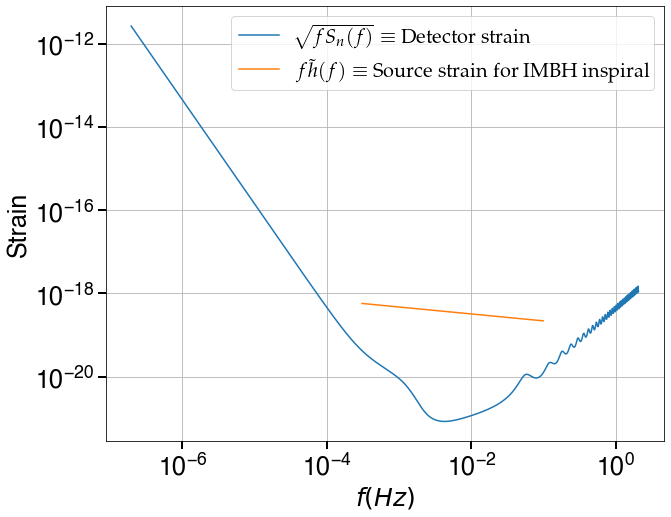

In [28]:
fig,ax=plt.subplots(figsize=(10,8))

""" Set the font and style of plot """
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


ax.set_xlabel(r'$f (Hz) $', fontsize=25)
ax.set_ylabel(r'Strain',fontsize=25)

ax.tick_params(which='both', width=2, length=8)

ax.plot(freq_arr,(freq_arr*Sn_arr)**(1./2),label=r'$\sqrt{f S_n(f)} \equiv$ Detector strain')
ax.plot(freq_window,freq_window*h_insp(freq_window,A),label=r'$f \tilde{h} (f) \equiv$ Source strain for IMBH inspiral')
#ax.plot(freq_window,(freq_window*S_tot_window)**(1./2),label=r'$\sqrt{f S_n(f)}$')
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim(1.0e-5, 1.0e0)
#ax.set_ylim(3.0e-22, 1.0e-15)
ax.grid('True')
ax.tick_params(labelsize=25)

ax.legend(fontsize=20)
plt.savefig('sourceVSdetectorStrain_m_2e4_equal_mass_1Gpc_a_init_400m_a_f_6m.pdf',dpi=fig.dpi,bbox_inches='tight')

In [29]:
S_med=(S_tot_window[0]+S_tot_window[len(S_tot_window)-1])/2
f_med=(f_max+f_init)/2

B=freq_window**(-7/3)/S_tot_window
s=(B[len(B)-1]-B[0])/(f_max-f_init)
B_line=B[0]+s*(freq_window-f_init)
Num_Delta_f=f_max-f_init
taylor_Delta_f=96/5*(np.pi)**(8/3)*Mc**(5/3)*(4*LISA.YEAR)*f_init**(11./3)

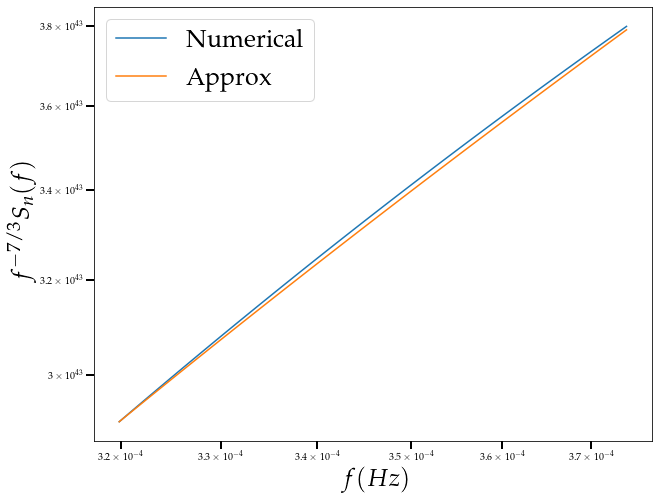

In [440]:
fi2g,ax2=plt.subplots(figsize=(10,8))

""" Set the font and style of plot """
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


ax2.set_xlabel(r'$f (Hz) $', fontsize=25)
ax2.set_ylabel(r'$f^{-7/3} S_n (f)$',fontsize=25)

ax2.tick_params(which='both', width=2, length=8)

ax2.plot(freq_window,freq_window**(-7/3)/S_analytic(freq_window,f_star,L,NC,Tobs),label='Numerical')
ax2.plot(freq_window,B[0]+s*(freq_window-f_init),label='Approx')

#ax2.plot(freq_window,,label=r'$S_n(f)$')
#ax.plot(freq_window,(freq_window*S_tot_window)**(1./2),label=r'$\sqrt{f S_n(f)}$')
ax2.set_yscale('log')
ax2.set_xscale('log')
#ax.set_xlim(1.0e-5, 1.0e0)
#ax.set_ylim(3.0e-22, 1.0e-15)
ax2.grid('True')
ax2.tick_params(labelsize=25)

ax2.legend(fontsize=25)
#plt.savefig('sourceVSdetectorStrain_m_2e4_equal_mass_1Gpc_4yr_a_init_450m.pdf',dpi=fig.dpi,bbox_inches='tight')

In [617]:
au=1.495e11

In [658]:
(16/5*A**2*f_init**(-7/3)*taylor_Delta_f/S_tot_window[0])**(1./2)

9.280332674319228

In [619]:
(16/5*A**2*f_init**(4/3)*96/5*(np.pi)**(8/3)*Mc**(5/3)*(4*LISA.YEAR)/S_tot_window[0])**(1./2)/rho

0.7538564201841941

In [659]:
abs(1-16*6**(1/2)/5*A*m**(7/6)*np.pi**(2/3)*(4*LISA.YEAR*eta/S_tot_window[0])**(1/2)/9.28/a_init)*100

0.0035848525777870677

In [674]:
8/5**(1/2)*m**2*(Tobs/S_tot_window[0])**(1/2)*eta/D_l/9.28*c/au

0.09232234194066115

In [666]:
def a0_constraint_chirp_analytic(m,eta,Dl,rho,Tobs,S0):
    return 0.0957*au*(eta/0.25)*(m/(2e4*Msun))**2*(Dl/Gpc)**(-1)*(rho/10)**(-1)*(Tobs/(4*LISA.YEAR))**(1/2)*(S0/4e-36)**(-1/2)

In [667]:
a0_constraint_chirp_analytic(m,eta,D_l,9.28,Tobs,S_tot_window[0])/c/a_init

1.0073460010225748

In [434]:
fminus=(f_max-f_init)/2
fplus=(f_max+f_init)/2
B0=B[len(B)-1]
B1=B[0]

In [337]:
(16/5*A**2*(B0+B1)*taylor_Delta_f/2)**(1/2)

9.968414946898482

In [347]:
(16/5*A**2*B1*taylor_Delta_f)**(1/2)

9.28033267431923

In [532]:
S_tot_window[0]

2.077691918608381e-38

In [675]:
a0_constraint_chirp_analytic(m,eta,D_l,10,Tobs,4e-36)/c/m

484.43244411718086